In [1]:
import harmonica as hm
import matplotlib.pyplot as plt
import numpy as np
import verde as vd
import xarray as xr
import magali as mg
import numba
import choclo

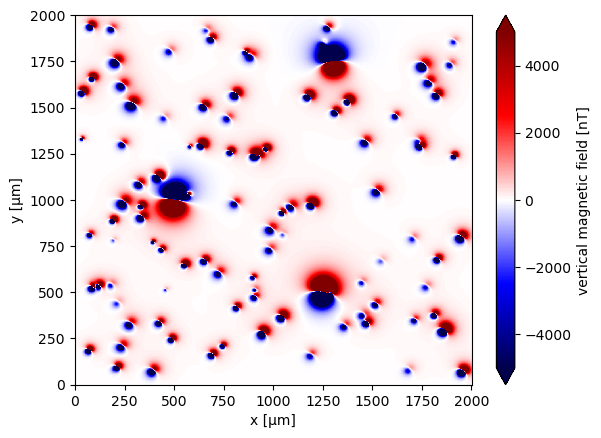

In [2]:
sensor_sample_distance = 5.0  # µm
region = [0, 2000, 0, 2000]  # µm
spacing = 2  # µm

true_inclination = 30
true_declination = 40
true_dispersion_angle = 5

size = 100

directions_inclination, directions_declination = mg.random_directions(
    true_inclination,
    true_declination,
    true_dispersion_angle,
    size=size,
    random_state=5,
)

dipoles_amplitude = abs(np.random.normal(0, 100, size)) * 1.0e-14

dipole_coordinates = (
    np.concatenate([np.random.randint(30, 1970, size), [1250, 1300, 500]]),  # µm
    np.concatenate([np.random.randint(30, 1970, size), [500, 1750, 1000]]),  # µm
    np.concatenate([np.random.randint(-20, -1, size), [-15, -15, -30]]),  # µm
)
dipole_moments = hm.magnetic_angles_to_vec(
    inclination=np.concatenate([directions_inclination, [10, -10, -5]]),
    declination=np.concatenate([directions_declination, [10, 170, 190]]),
    intensity=np.concatenate([dipoles_amplitude, [5e-11, 5e-11, 5e-11]]),
)

data = mg.dipole_bz_grid(
    region, spacing, sensor_sample_distance, dipole_coordinates, dipole_moments
)

data.plot.pcolormesh(cmap="seismic", vmin=-5000, vmax=5000)

In [3]:
coordinates = vd.grid_coordinates(
    region=region,  # µm
    spacing=spacing,  # µm
    extra_coords=sensor_sample_distance,
)

In [4]:
len(coordinates[1])

1001

In [5]:
# Copyright (c) 2024 The Magali Developers.
# Distributed under the terms of the BSD 3-Clause License.
# SPDX-License-Identifier: BSD-3-Clause
#
# This code is part of the Fatiando a Terra project (https://www.fatiando.org)
#
"""
Classes for inversions.
"""

import numpy as np
import scipy as sp
import verde.base as vdb
import numba

class MagneticMomentBz:
    def __init__(self, location):
        self.location = location
        # The estimated parameters. Start them with None
        self.dipole_moment_ = None
        self.jacobian = None

    def fit(self, coordinates, data):
        "data - bz vector"
        coordinates, data, _ = vdb.check_fit_input(coordinates, data, weights=None)
        x, y, z = vdb.n_1d_arrays(coordinates, 3)
        x_c, y_c, z_c = vdb.n_1d_arrays(self.location, 3)
        factor = choclo.constants.VACUUM_MAGNETIC_PERMEABILITY / (4 * np.pi)
        n_data = len(x)
        n_params = 3
        jacobian = np.empty((n_data, n_params))
        for i in range(n_data):
            r = choclo.utils.distance_cartesian(
                x[i],
                y[i],
                z[i],
                x_c,
                y_c,
                z_c,
            )


    @numba.jit(nopython=True, parallel=True)
    def _calculate_jacobian(x,y,z,x_c,y_c,z_c, jacobian):
        factor = choclo.constants.VACUUM_MAGNETIC_PERMEABILITY / (4 * np.pi)
        for i in numba.prange(x.size):
            r = choclo.utils.distance_cartesian(
                x[i],
                y[i],
                z[i],
                x_c,
                y_c,
                z_c,
            )
            jacobian[i, 0] = factor * choclo.point.kernel_eu(
                x[i],
                y[i],
                z[i],
                x_c,
                y_c,
                z_c,
                r,
            )
            jacobian[i, 1] = factor * choclo.point.kernel_nu(
                x[i],
                y[i],
                z[i],
                x_c,
                y_c,
                z_c,
                r,
            )
            jacobian[i, 2] = factor * choclo.point.kernel_uu(
                x[i],
                y[i],
                z[i],
                x_c,
                y_c,
                z_c,
                r,
            )

            

In [6]:
inv = MagneticMomentBz(dipole_coordinates)
inv.fit(coordinates, data)